**1. Read Data**

In [99]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
filename = "data_cntn19.csv"

In [100]:
# read data from files
data = pd.read_csv(filename)
print("Shape of data:", data.shape)
data.head()

Shape of data: (203, 4)


,ImmunoPhenotype,sum_frameshift_expression,max_frameshift_expression,PFS
0,Desert,65.052090,37.23766,1.971253
1,Desert,124.985740,33.15245,5.716632
2,Desert,140.991170,36.67102,11.827515
3,Desert,276.583909,35.75460,0.032854
4,Desert,222.826690,33.69304,7.490760


**2. Examine Data**

We find out that our data has 203 rows and 4 columns: 3 are numerical, and 1 is categorical. 
Mean of columns in our dataset:

   - ImmunoPhenotype: types of tumor immune phenotypes in each patient. It has 4 values: Desert, Excluded, Infiltrated (3 phenotypes) and No_IF (No infomation)

   - sum_frameshift_expression: total frameshifts each patient was recorded

   - max_frameshift_expression: maximum frameshifts each patient was recorded in a week

  - PFS: their living times (in weeks): The value need to predict

We will take a closer look at our data by plotting relations and correlations between predictors and FPS

In [101]:
# Count ImmunoPhenotype's unique values 
Immuno_count = data["ImmunoPhenotype"].value_counts()
print(Immuno_count)

# missing value rate
na_rate = data.isna().sum().sum() / data.size
print("\nMissing value rate:", na_rate)

No_IF          137
Infiltrated     51
Desert          14
Excluded         1
Name: ImmunoPhenotype, dtype: int64

Missing value rate: 0.0


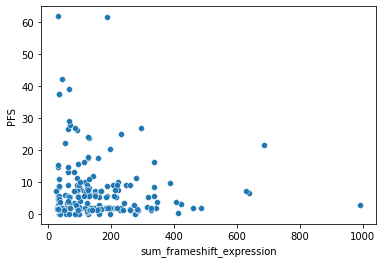

In [102]:
# Relation between sum_frameshift_expression and PFS
plot1 = sea.scatterplot(x="sum_frameshift_expression", y="PFS", \
     data=data)
plt.show()

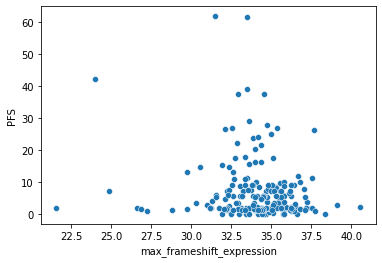

In [103]:
# Relation between max_frameshift_expression and PFS
sea.scatterplot(x="max_frameshift_expression", y="PFS", \
     data=data)
plt.show()

<AxesSubplot:ylabel='PFS'>

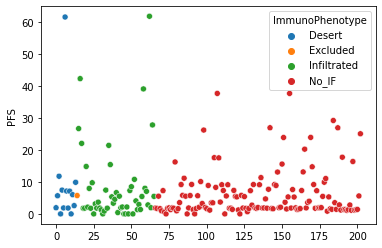

In [104]:
# Relation between ImmunoPhenotype and PFS
sea.scatterplot(x=data.index, \
    y="PFS", hue="ImmunoPhenotype", data=data)

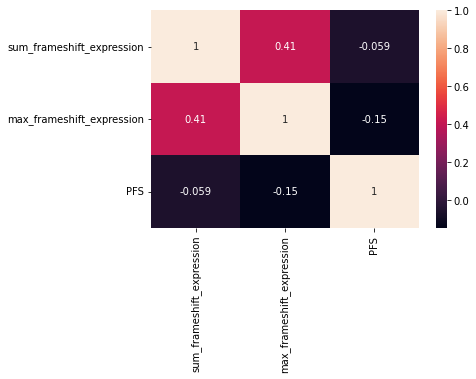

In [105]:
# Correlation between
corr= data.corr()
sea.heatmap(corr , annot = True)
plt.show()

Through correlation heat map, we find out that sum_frameshift_expression's impact on PFS is really low

**3. Preprocessing**

We find that the data has no missing value, so filling the NULL values is not necessary. We also find out that there is one unusual value in the ImmunoPhenotype column (Excluded). 

We will group it with the least frequent category (Desert) 

We will split our data into training set and validation set, with the ratio of 70:30 (70% of the original dataset is used for training models, the rest is used for testing). 

To make sure validation set doesn't contain categorical value(s) that couldn't be found in training set, we will first split same-category data points (with the given ratio), then combine those categories to form training set and validation set. 

After doing Training - Validation split, we will encode the categorical column by using One Hot Encoding techniques (since we will need dummy variables for some regression models later on)

In [106]:
# Replace values
data["ImmunoPhenotype"][data["ImmunoPhenotype"] == "Excluded"] = "Desert"
Immuno_count = data["ImmunoPhenotype"].value_counts()
print(Immuno_count, '\n')

No_IF          137
Infiltrated     51
Desert          15
Name: ImmunoPhenotype, dtype: int64 



C:\Users\Administration\AppData\Local\Temp\ipykernel_7560\1931675228.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["ImmunoPhenotype"][data["ImmunoPhenotype"] == "Excluded"] = "Desert"


In [107]:
# Train - test split
from sklearn.model_selection import train_test_split

training_set = pd.DataFrame()
validation_set = pd.DataFrame()
for value in data.ImmunoPhenotype.unique():
    train , test = train_test_split(data[data["ImmunoPhenotype"] == value], train_size=0.7)
    training_set = pd.concat([training_set, train])
    validation_set = pd.concat([validation_set, test])

# show Train - test split result
print("Training set shape:", training_set.shape)
print("Validation set shape:", validation_set.shape, "\n")
print("Training set values count\n",training_set["ImmunoPhenotype"].value_counts())
print("\nValidation set values count\n",validation_set["ImmunoPhenotype"].value_counts())

Training set shape: (140, 4)
Validation set shape: (63, 4) 

Training set values count
 No_IF          95
Infiltrated    35
Desert         10
Name: ImmunoPhenotype, dtype: int64

Validation set values count
 No_IF          42
Infiltrated    16
Desert          5
Name: ImmunoPhenotype, dtype: int64


In [108]:
# One Hot Encoding

training_set = pd.get_dummies(training_set, columns=["ImmunoPhenotype"])
validation_set = pd.get_dummies(validation_set, columns=["ImmunoPhenotype"])

In [109]:
# Spilt the labels (PFS column) from the training set and validation set
X_train = training_set.drop("PFS", axis = 1)
Y_train = training_set["PFS"]
X_val = validation_set.drop("PFS", axis = 1)
Y_val = validation_set["PFS"]

**4. Building Models**

After we have preprocessed our data, we will build many regression models to predict PFS based on training set, validate them using validation set, and assess their performances by Mean Absolute Error (MAE).   

The models that will be chosen are:

 - Random Forest Regression

 - Decision Tree Regression

- Partial Least Square Regression

- Ridge Regression

 - Lasso Regression

*a. Random Forest Regression*: 

We build serveral Random Forest Regression models with diffirent *n_estimators* parameter values to find out the best one (the one with the lowest MAE). Our *n_estimators* parameter will be in range [1, 100] (step = 5 for every *n_estimators* >= 5)

n_estimators value with the smallest MAE: 15
Smallest MAE value: 6.526497516935449


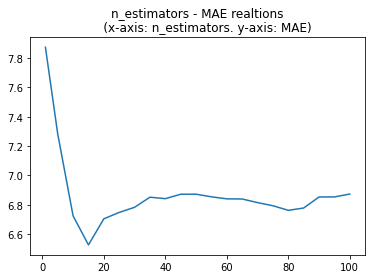

In [110]:
# Random Forest:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# n_est: diffirent n_estimators parameter values
# err: corresponding MAE of each n_estimators value
n_est = [1]
n_est += list(range(5, 105, 5))
err = []

# build model and calculate MAE
for i in range (len(n_est)):
    rf = RandomForestRegressor(n_estimators=n_est[i], random_state=0)
    rf.fit(X_train, Y_train)
    Y_pred = rf.predict(X_val)
    rf_mae = mean_absolute_error(Y_pred, Y_val)
    err.append(rf_mae)

# plot graphs to show the relations between n_estimators and MAE
sea.lineplot(x=n_est, y=err).set(title= "n_estimators - MAE realtions\n \
    (x-axis: n_estimators. y-axis: MAE)")

# find out the n_estimators value with smallest MAE
idx = np.argmin(err)
mae1 = err[idx]
print("n_estimators value with the smallest MAE:", n_est[idx])
print("Smallest MAE value:", mae1)

*b. Decision Tree Regression*: 

We build serveral Decisiom Tree Regression models with diffirent *max_depth* parameter values and an unlimited-depth model to find out the best one (the one with the lowest MAE). Our *max_depth* parameter will be in range [5, 100] (step = 5) 

max_depth value with the smallest MAE: 0
Smallest MAE value: 7.820060873730159


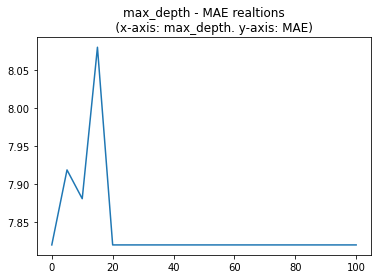

In [111]:
# Decision Tree:
from sklearn.tree import DecisionTreeRegressor

# depth: diffirent max_depth parameter values
# err: corresponding MAE of each n_estimators value
# Note: with the unlimited-depth model, we will define max_depth = 0 for 
#   ease of implementaion
depth = list(range(0, 105, 5))
err = []

# build model and calculate MAE
for i in range (len(depth)):
    if (i != 0):
        dt = DecisionTreeRegressor(max_depth = depth[i],random_state=0)
    else:
        dt = DecisionTreeRegressor(random_state=0)
    dt.fit(X_train, Y_train)
    Y_pred = dt.predict(X_val)
    dt_mae = mean_absolute_error(Y_pred, Y_val)
    err.append(dt_mae)

# plot graphs to show the relations between max_depth and MAE
sea.lineplot(x=depth, y=err).set(title= "max_depth - MAE realtions\n \
    (x-axis: max_depth. y-axis: MAE)")

# find out max_depth value with the smallest MAE
idx = np.argmin(err)
mae2 = err[idx]
print("max_depth value with the smallest MAE:", depth[idx])
print("Smallest MAE value:", mae2)


*c. Partial Least Square Regression*: 

We build serveral Partial Least Square Regression models with diffirent *n_components* parameter values to find out the best one (the one with the lowest MAE). Our *n_components* parameter will be in range [1;5] (step = 1), since our data (after being encoded) only has 5 components 

n_components value with the smallest MAE: 1
Smallest MAE value: 6.355667708458621


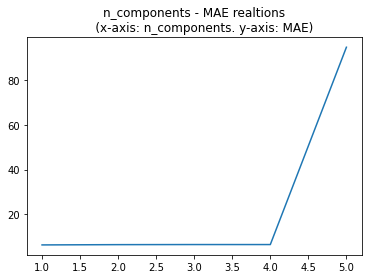

In [112]:
# Partial Least Square
from sklearn.cross_decomposition import PLSRegression

# comp: diffirent n_components parameter values
# err: corresponding MAE of each n_estimators value
comp = list(range(1, 6, 1))
err= []

# build model and calculate MAE
for i in range (len(comp)):
    plsr = PLSRegression(n_components=comp[i])
    plsr.fit(X_train, Y_train)
    Y_pred = plsr.predict(X_val)
    plsr_mae = mean_absolute_error(Y_pred, Y_val)
    err.append(plsr_mae)

# plot graphs to show the relations between max_depth and MAE
sea.lineplot(x=comp, y=err).set(title= "n_components - MAE realtions\n \
    (x-axis: n_components. y-axis: MAE)")

# find out the max_depth value with smallest MAE
idx = np.argmin(err)
mae3 = err[idx]
print("n_components value with the smallest MAE:", comp[idx])
print("Smallest MAE value:", mae3)


*d. Ridge Regression*: 

We build serveral Ridge Regression models with diffirent *lambda* parameter values to find out the best one (the one with the lowest MAE). Our *lambda* parameter will be in range [0;500] (step = 10)

c:\Python\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=1.02543e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Lambda value with the smallest MAE: 500
Smallest MAE value: 6.1317969255400095


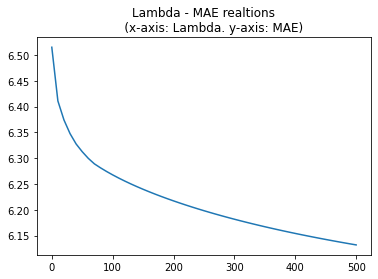

In [113]:
# Ridge Regression
from sklearn.linear_model import Ridge

# ridge_lambda: diffirent n_components parameter values
# err: corresponding MAE of each n_estimators value
ridge_lambda = list(range(0, 510, 10))
err= []

# build model and calculate MAE
for i in range (len(ridge_lambda)):
    ridge_reg = Ridge(alpha=ridge_lambda[i])
    ridge_reg.fit(X_train, Y_train)
    Y_pred = ridge_reg.predict(X_val)
    ridge_mae = mean_absolute_error(Y_pred, Y_val)
    err.append(ridge_mae)

# plot graphs to show the relations between max_depth and MAE
sea.lineplot(x=ridge_lambda, y=err).set(title= "Lambda - MAE realtions\n \
    (x-axis: Lambda. y-axis: MAE)")

# find out the max_depth value with smallest MAE
idx = np.argmin(err)
mae4 = err[idx]
print("Lambda value with the smallest MAE:", ridge_lambda[idx])
print("Smallest MAE value:", mae4)

*e. Lasso Regression*: 

We build serveral Lasso Regression models with diffirent *lambda* parameter values to find out the best one (the one with the lowest MAE). Our *lambda* parameter will be in range [0;500] (step = 10)

C:\Users\Administration\AppData\Local\Temp\ipykernel_7560\1943340766.py:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  ridge_reg.fit(X_train, Y_train)
c:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Python\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.804e+03, tolerance: 1.467e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Lambda value with the smallest MAE: 80
Smallest MAE value: 5.910435851325068


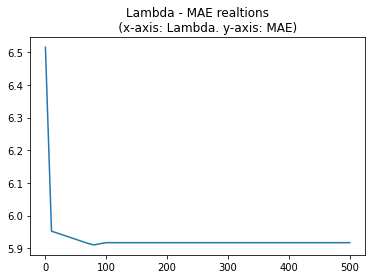

In [114]:
# Lasso Regression
from sklearn.linear_model import Lasso

# ridge_lambda: diffirent n_components parameter values
# err: corresponding MAE of each n_estimators value
lasso_lambda = list(range(0, 510, 10))
err= []

# build model and calculate MAE
for i in range (len(lasso_lambda)):
    ridge_reg = Lasso(alpha=lasso_lambda[i])
    ridge_reg.fit(X_train, Y_train)
    Y_pred = ridge_reg.predict(X_val)
    lasso_mae = mean_absolute_error(Y_pred, Y_val)
    err.append(lasso_mae)

# plot graphs to show the relations between max_depth and MAE
sea.lineplot(x=lasso_lambda, y=err).set(title= "Lambda - MAE realtions\n \
    (x-axis: Lambda. y-axis: MAE)")

# find out the max_depth value with smallest MAE
idx = np.argmin(err)
mae5 = err[idx]
print("Lambda value with the smallest MAE:", ridge_lambda[idx])
print("Smallest MAE value:", mae5)

**5. Compare Models**

<AxesSubplot:>

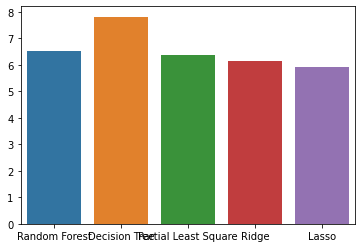

In [115]:
# Compare models' smallest MAEs
models = ["Random Forest", "Decision Tree", \
        "Partial Least Square", \
        "Ridge", "Lasso"] 

min_mae = [mae1, mae2, mae3, mae4, mae5]

sea.barplot(x=models, y=min_mae)